<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DL-SatelliteImagery/Satellite_Imagery_DeepLearning-SaveLoadModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code from Part 1 Exercise - Satellite Imagery Data Preparation 



In [1]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [2]:
minmaxscaler = MinMaxScaler()

In [3]:
dataset_root_folder = '/content/drive/MyDrive/Colab Notebooks/datasets/satellite/'

In [4]:
dataset_name = "DubaiDataset/"

In [5]:
image_patch_size = 256

In [6]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [8]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


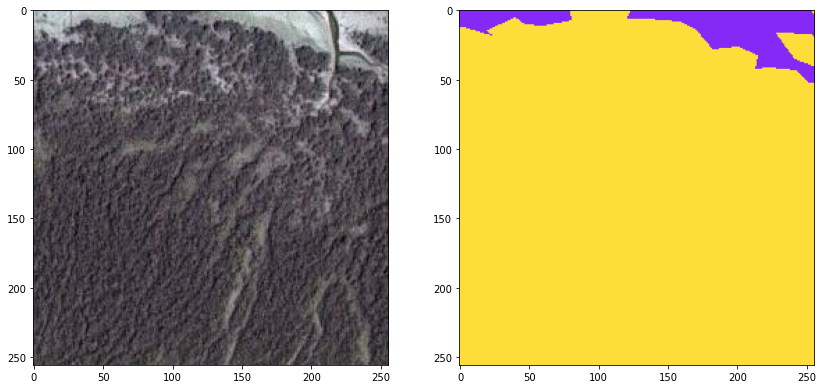

In [9]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [10]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [11]:
label = individual_patched_mask

In [12]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [14]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [15]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [16]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


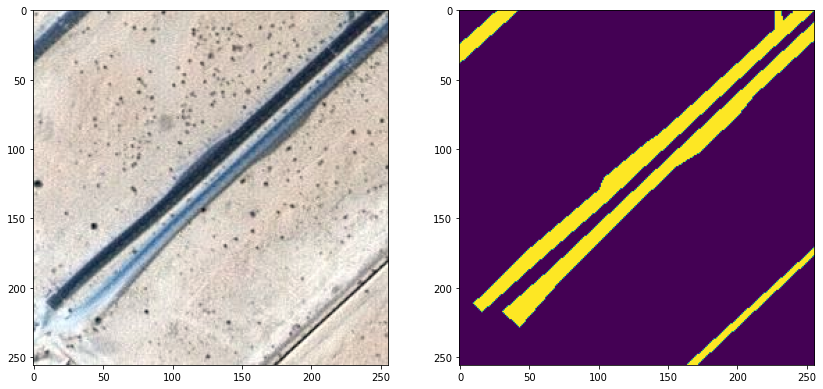

In [17]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [18]:
total_classes = len(np.unique(labels))

In [19]:
total_classes

6

In [20]:
from tensorflow.keras.utils import to_categorical 

In [21]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [22]:
master_trianing_dataset = image_dataset

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [26]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [27]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Coding for Part 2: Deep Learning with Satellite Imagery Data

In [28]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [30]:
from keras import backend as K

In [31]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [32]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [33]:
metrics = ["accuracy", jaccard_coef]

In [34]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [35]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [36]:
model = get_deep_learning_model()

In [37]:
# Please uncomment this line to get model confiuration
# model.get_config()

## Generating Loss Function 

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [38]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [39]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [40]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [41]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [42]:
total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [43]:
import tensorflow as tf

In [44]:
tf.keras.backend.clear_session()


In [45]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [47]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/100
51/51 [==============================] - 25s 241ms/step - loss: 1.0066 - accuracy: 0.5014 - jaccard_coef: 0.2398 - val_loss: 0.9921 - val_accuracy: 0.6364 - val_jaccard_coef: 0.3555
Epoch 2/100
51/51 [==============================] - 9s 174ms/step - loss: 0.9797 - accuracy: 0.6694 - jaccard_coef: 0.3925 - val_loss: 0.9710 - val_accuracy: 0.6974 - val_jaccard_coef: 0.4202
Epoch 3/100
51/51 [==============================] - 9s 175ms/step - loss: 0.9666 - accuracy: 0.7051 - jaccard_coef: 0.4465 - val_loss: 0.9608 - val_accuracy: 0.7354 - val_jaccard_coef: 0.4684
Epoch 4/100
51/51 [==============================] - 9s 175ms/step - loss: 0.9571 - accuracy: 0.7426 - jaccard_coef: 0.4885 - val_loss: 0.9668 - val_accuracy: 0.7024 - val_jaccard_coef: 0.4669
Epoch 5/100
51/51 [==============================] - 9s 181ms/step - loss: 0.9507 - accuracy: 0.7552 - jaccard_coef: 0.5133 - val_loss: 0.9685 - val_accuracy: 0.6926 - val_jaccard_coef: 0.4524
Epoch 6/100
51/51 [===============

In [48]:
history_a = model_history

In [ ]:
#history_a.history

{'loss': [0.9970040321350098,
  0.9727678298950195,
  0.9620695114135742,
  0.9558483958244324,
  0.9514367580413818,
  0.9474132061004639,
  0.9418561458587646,
  0.9373967051506042,
  0.9337165951728821,
  0.9303786754608154],
 'accuracy': [0.5842210650444031,
  0.6958295702934265,
  0.7204334735870361,
  0.7392511367797852,
  0.7517362833023071,
  0.7615696787834167,
  0.7753322720527649,
  0.7885444164276123,
  0.7976995706558228,
  0.8057615756988525],
 'jaccard_coef': [0.2803662121295929,
  0.3983546495437622,
  0.4502638578414917,
  0.48679396510124207,
  0.5051699876785278,
  0.5253534317016602,
  0.5531865358352661,
  0.5793193578720093,
  0.5981342792510986,
  0.6129477620124817],
 'val_loss': [0.9835827350616455,
  0.9630498886108398,
  0.9638665318489075,
  0.9630216360092163,
  0.9613699913024902,
  0.970794677734375,
  0.9527684450149536,
  0.951079785823822,
  0.951518714427948,
  0.9524847865104675],
 'val_accuracy': [0.6597653031349182,
  0.7131726145744324,
  0.711631

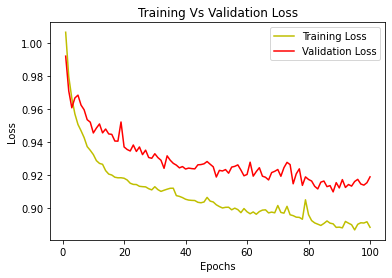

In [49]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

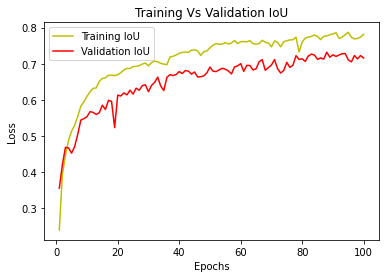

In [50]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [51]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 51}

In [52]:
y_pred = model.predict(X_test)

5/5 [==============================] - 2s 76ms/step


In [53]:
len(y_pred)

142

In [54]:
#y_pred

In [55]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [56]:
len(y_pred_argmax)

142

In [57]:
#y_pred_argmax

In [58]:
y_test_argmax = np.argmax(y_test, axis=3)

In [59]:
#y_test_argmax

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [60]:
import random

In [102]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = saved_model.predict(test_image_input)
#prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 229ms/step


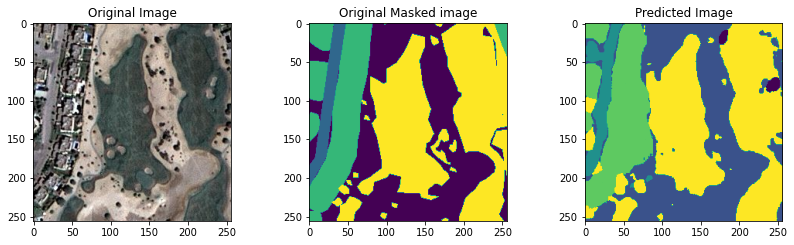

In [103]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


# Model saving and reloading (with custom loss and custom metrics)

- loss
  - 'dice_loss_plus_1focal_loss': total_loss
- Metrics
  - jaccard_coef: jaccard_coef

In [65]:
#model.get_config()

In [66]:
model.save('satellite-imagery.h5')

In [67]:
!ls -lah

total 23M
drwxr-xr-x 1 root root 4.0K Oct 28 21:57 .
drwxr-xr-x 1 root root 4.0K Oct 28 21:28 ..
drwxr-xr-x 4 root root 4.0K Oct 27 13:27 .config
drwx------ 7 root root 4.0K Oct 28 21:32 drive
drwxr-xr-x 1 root root 4.0K Oct 27 13:28 sample_data
-rw-r--r-- 1 root root  23M Oct 28 21:57 satellite-imagery.h5


In [71]:
from keras.models import load_model 

In [96]:
saved_model = load_model('/content/satellite-imagery.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 
                                          'jaccard_coef': jaccard_coef}))

In [94]:
model.loss.name

'dice_loss_plus_1focal_loss'

In [104]:
#saved_model.get_config()

## Performing Prediction using the custom image from Google Map

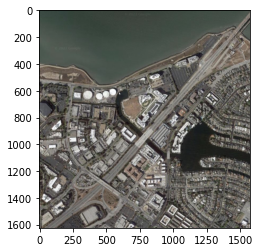

In [105]:
plt.imshow(Image.open('/content/fc-img1.jpg'))

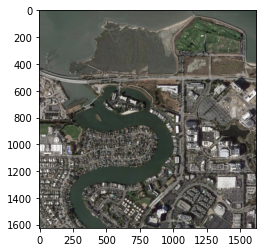

In [106]:
plt.imshow(Image.open('/content/fc-img2.jpg'))

In [115]:
image = Image.open('/content/fc-img1.jpg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)

In [116]:
prediction = saved_model.predict(image)


1/1 [==============================] - 0s 29ms/step


In [117]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

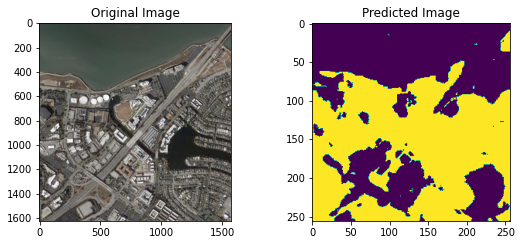

In [119]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/fc-img1.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)